In [1]:
from unsupervised_topic_segmentation import core, eval, types, dataset
import create_test_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
# read transcripts.pickle
with open('transcripts.pickle', 'rb') as handle:
    transcripts = pickle.load(handle)

Options:
- datasets: `types.TopicSegmentationDatasets.AMI`, `types.TopicSegmentationDatasets.ICSI` _(need to download and implement in unsupervised_topic_segmentation/dataset.py)_
- algorithms: `types.BERTSegmentation`, `types.RandomSegmentation`, `types.TopicSegmentationAlgorithm.EvenSegmentation` _(SBERT not implemented)_

Hyperparams to consider for `BERTSegmentation`:
- `PARALLEL_INFERENCE_INSTANCES = 20` in `core.py`: infer multiple meetings at once
- `MAX_SEGMENTS_CAP`: True or False, default True. "Add a max segment limit so there are not too many segments"; in this implementation, "local maxima are sorted by depth_score value and we take only the first K where the K+1th local maxima is lower then the threshold". False "is the vanilla TextTiling used for Pk optimization". 
- `MAX_SEGMENTS_CAP__AVERAGE_SEGMENT_LENGTH`: used as cap if above is True, int default 60. This was originally supposed to be in seconds (see explanation below) but we can easily make it refer to words or sentences.
- `TEXT_TILING`: additional tiling hyperparams. Set to `types.TextTilingHyperparameters` with below additional hyperparams, otherwise defaults to None (which throws error).

Additional hyperparams in `TextTilingHyperparameters`:
- `SENTENCE_COMPARISON_WINDOW`: int default 15. Number of sentences in each non-overlapping window to consider as chunk.
- `SMOOTHING_PASSES` int default 2. Number of smoothing iterations on similarity scores.
- `SMOOTHING_WINDOW`: int default 1. Neighborhood considered in smoothing similarity scores (unit is chunks).
- `TOPIC_CHANGE_THRESHOLD`: float default 0.6.

Hyperparams for `RandomSegmentation`:
- `random_threshold`

Hyperparams for `EvenSegmentation`:
- `k`: Number of sentences per segment

Note: the meeting duration is used in the original code in the following way, when `MAX_SEGMENTS_CAP` is True: The total meeting duration for each meeting is divided by `MAX_SEGMENTS_CAP_AVERAGE_SEGMENT_LENGTH` to determine the number of max segments.

In [3]:
old_algorithm = types.BERTSegmentation(
    sentence_comparison_window=50,
    text_tiling=types.OriginalSegmentation(
        smoothing_passes=2,
        smoothing_window=1,
        topic_change_threshold=0.6,
        max_segments_cap=True,
        max_segments_cap__average_segment_length=120))
new_algorithm = types.BERTSegmentation(
    sentence_comparison_window=50,
    text_tiling=types.NewSegmentation(
        stdevs=1))

new_algorithm

BERTSegmentation(SENTENCE_COMPARISON_WINDOW=50, TEXT_TILING=NewSegmentation(STDEVS=1))

Just to run inference (no eval), use `core.topic_segmentation` with arguments:
- `topic_segmentation_algorithm`: choose from above
- `df`: transcript pandas dataframe with columns below
- `meeting_id_col_name`: str for col of meetings to produce splits within
- `start_col_name`: str for col with start time of caption (barely used, could cut)
- `end_col_name`: str for col with end time of caption (barely used, could cut)
- `caption_col_name`: str for col of sentence strings

In [4]:
test_data = pd.DataFrame(data={'meeting_id':'d0a7e5864959','caption':transcripts['d0a7e5864959']})
test_data = dataset.add_durations(test_data)  # "duration" column is just number of words
test_data = dataset.preprocessing(test_data,min_caption_len=5)  # note that this adds (old) `index` column, but topic_segmentation uses actual index
test_data

,index,meeting_id,caption,end_time,start_time
0,0,d0a7e5864959,And older woman Jocasta Zamarripa.,5,0
1,1,d0a7e5864959,"Shortly, Alderman Rainey and Alderman Hamilton...",15,5
2,2,d0a7e5864959,So let's get started.,19,15
3,3,d0a7e5864959,"Item nber 211814, reappointment of Brian Rott ...",36,19
4,4,d0a7e5864959,"Mr. Brian Rott, I see you.",42,36
...,...,...,...,...,...
447,454,d0a7e5864959,And that concludes our committee meeting today.,4349,4342
448,455,d0a7e5864959,Thank you.,4351,4349
449,456,d0a7e5864959,See you all in the community.,4357,4351
450,457,d0a7e5864959,Thanks to additionally.,4360,4357


In [5]:
core.topic_segmentation(
    topic_segmentation_algorithm=new_algorithm,
    df=test_data,
    meeting_id_col_name='meeting_id',
    start_col_name='start_time',
    end_col_name='end_time',
    caption_col_name='caption')

{'d0a7e5864959': [382, 427, 448]}

In [6]:
i = 112
test_data.iloc[(i-10):(i+10)]

,index,meeting_id,caption,end_time,start_time
102,105,d0a7e5864959,"Excellent, excellent.",1018,1016
103,106,d0a7e5864959,Do me a favor and send an invitation to the co...,1034,1018
104,107,d0a7e5864959,We'll definitely do that.,1038,1034
105,108,d0a7e5864959,"All right, anybody have any questions?",1044,1038
106,109,d0a7e5864959,Any of my colleagues have any questions?,1051,1044
107,110,d0a7e5864959,We have been joined by Alderman Hamilton.,1058,1051
108,111,d0a7e5864959,"Good to see you, Alderman Hamilton.",1064,1058
109,112,d0a7e5864959,"And I'll move approval, Mr. Chair.",1070,1064
110,113,d0a7e5864959,"Thank you, Alderman Hamilton moves approval.",1076,1070
111,114,d0a7e5864959,"Hearing no objections or order, thank you so m...",1085,1076


In [7]:
results,labels,topics,doc_count = create_test_data.generate_segment()
test_data = pd.DataFrame(data={'caption':results,'label':labels,'meeting_id':1})
test_data = dataset.add_durations(test_data)
test_data = test_data[['meeting_id','start_time','end_time','caption','label']]
test_data = dataset.preprocessing(test_data, 'caption')  # note that this adds (old) `index` column, but topic_segmentation uses actual index
test_data

,index,meeting_id,start_time,end_time,caption,label
0,0,1,0,13,25th 2021 meeting of the Fire and Police Commi...,0
1,1,1,13,16,Presence our commissioners.,0
2,2,1,16,27,I don't see a values of values are you with us?,0
3,4,1,31,38,"Commissioner Valos, Cockcroft, brother, Wilson...",0
4,5,1,38,54,Also present are Chief of Staff Nick DeSeatto ...,0
...,...,...,...,...,...,...
632,1193,1,10455,10460,"No, it's just the lease.",2
633,1196,1,10467,10486,"I will add, we did go through the third ward d...",2
634,1197,1,10486,10493,They did review and approve the project.,2
635,1204,1,10504,10511,There's been a motion and a second.,2


In [8]:
eval.eval_topic_segmentation(
    topic_segmentation_algorithm=new_algorithm,
    input_df=test_data,
    verbose=True)

[106, 141, 169, 173, 223, 241, 433, 484]
Pk on 1 meetings: 0.1625
WinDiff on 1 meetings: 1.0


{'average_Pk_': 0.1625, 'average_windiff_': 1.0}

In [9]:
even_algorithm = types.EvenSegmentation(k=100)
eval.eval_topic_segmentation(
    topic_segmentation_algorithm=even_algorithm,
    input_df=test_data,
    verbose=True)

Even segmentation: [0, 100, 200, 300, 400, 500, 600]
Pk on 1 meetings: 0.1625
WinDiff on 1 meetings: 1.0


{'average_Pk_': 0.1625, 'average_windiff_': 1.0}

In [10]:
random_algorithm = types.RandomSegmentation(random_threshold=0.99)
eval.eval_topic_segmentation(
    topic_segmentation_algorithm=random_algorithm,
    input_df=test_data,
    verbose=True)

Random segmentation: [30, 55, 79, 128, 360, 466, 508]
Pk on 1 meetings: 0.1625
WinDiff on 1 meetings: 0.9375


{'average_Pk_': 0.1625, 'average_windiff_': 0.9375}

In [11]:
iterations = 2
test_algorithm = types.BERTSegmentation(
    sentence_comparison_window=50,
    text_tiling=types.NewSegmentation(stdevs=1))
even_algorithm = types.EvenSegmentation(k=100)
random_algorithm = types.RandomSegmentation(random_threshold=0.99)

outputs = eval.multiple_eval(
    create_test_data.generate_segment,
    iterations,test_algorithm,even_algorithm,random_algorithm)

In [12]:
outputs

,test_pk,test_windiff,even_pk,even_windiff,random_pk,random_windiff,n_captions,n_segments
0,0.477912,0.477912,0.409639,0.461847,0.453815,0.453815,383,9
1,0.705882,1.000000,0.705882,1.000000,0.705882,0.983193,533,2


In [3]:
transcript_id = '28e79cb9646d'
manual_transcript = transcripts[transcript_id]
with open(f'transcript_{transcript_id}_labels.pickle', 'rb') as handle:
    manual_labels = pickle.load(handle)
test_data = pd.DataFrame(data={'caption':manual_transcript,'label':manual_labels,'meeting_id':1})
test_data = dataset.add_durations(test_data)
test_data = test_data[['meeting_id','start_time','end_time','caption','label']]
test_data = dataset.preprocessing(test_data, 'caption')  # note that this adds (old) `index` column, but topic_segmentation uses actual index
test_data

,index,meeting_id,start_time,end_time,caption,label
0,0,1,0,31,The plan commission today is June 27th and we ...,0
1,1,1,31,46,All right Commissioner Allison Nemec is excuse...,0
2,3,1,47,52,Hello and Commissioner Brianna Saaz-Perez.,0
3,6,1,54,57,Commissioner Willie Smith.,0
4,8,1,58,63,Okay and Commissioner Ronell Washington.,0
...,...,...,...,...,...,...
944,1148,1,17649,17654,"Okay, the ayes have it.",0
945,1149,1,17654,17663,"Thank you so much, and have a great afternoon.",0
946,1150,1,17663,17678,Thank you to everyone who's been here with us ...,0
947,1152,1,17680,17683,"Thank you, Chairwoman.",0


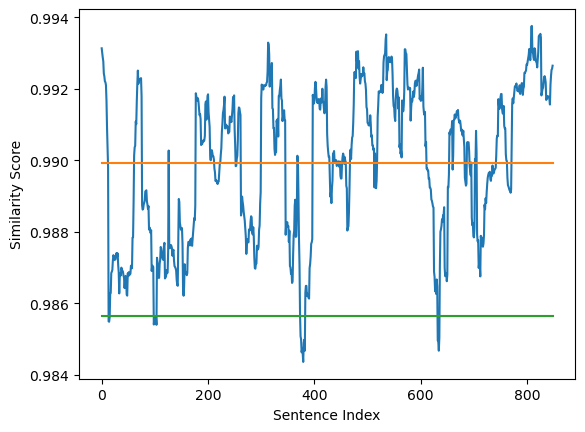

[114, 198, 203, 479, 734]
Pk on 1 meetings: 0.28128587830080365
WinDiff on 1 meetings: 0.41446613088404133
Even segmentation: [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]
Pk on 1 meetings: 0.5373134328358209
WinDiff on 1 meetings: 0.6039035591274398
Random segmentation: [111, 151, 291, 557, 908]
Pk on 1 meetings: 0.5487944890929966
WinDiff on 1 meetings: 0.5487944890929966


{'average_Pk_': 0.5487944890929966, 'average_windiff_': 0.5487944890929966}

In [4]:
test_algorithm = types.BERTSegmentation(
    sentence_comparison_window=50,
    text_tiling=types.NewSegmentation(stdevs=2))
eval.eval_topic_segmentation(
    topic_segmentation_algorithm=test_algorithm,
    input_df=test_data,
    binary_label_encoding=True,
    verbose=True)

even_algorithm = types.EvenSegmentation(k=100)
eval.eval_topic_segmentation(
    topic_segmentation_algorithm=even_algorithm,
    input_df=test_data,
    binary_label_encoding=True,
    verbose=True)

random_algorithm = types.RandomSegmentation(random_threshold=0.99)
eval.eval_topic_segmentation(
    topic_segmentation_algorithm=random_algorithm,
    input_df=test_data,
    binary_label_encoding=True,
    verbose=True)